In [1]:
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings


embedding_function = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)


C:\Users\Asus\AppData\Local\Temp\ipykernel_42316\4164606507.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(
c:\Users\Asus\.conda\envs\agent3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
retriever = db.as_retriever(search_type="mmr", search_kwargs = {"k": 3})


In [3]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Gym History & Founder, Operating Hours, Membership Plans, Fitness Classes, Personal Trainers, and Facilities & Equipment of Peak Performance Gym",
)


@tool
def off_topic():
    """Catch all Questions NOT related to Peak Performance Gym's history, hours, membership plans, fitness classes, trainers, or facilities"""
    return "Forbidden - do not respond to the user"


tools = [retriever_tool, off_topic]

In [4]:
from typing import Annotated,Sequence, Literal, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
from typing import Literal

from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq          # 👈 Groq instead of OpenAI
from langgraph.graph import END, StateGraph, START
from dotenv import load_dotenv
load_dotenv()

# ✅ define the model ONCE at module level, not inside the function
llm = ChatGroq(
    model="llama-3.1-8b-instant",            # or "llama-3.1-70b-versatile"
    temperature=0,
)
llm_with_tools = llm.bind_tools(tools)       # tools must be defined elsewhere


def agent(state):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def should_continue(state) -> Literal["tools", END]:
    from langchain_core.messages import ToolMessage, AIMessage
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # If last message is a ToolMessage (tool result)
    if isinstance(last_message, ToolMessage):
        # If it's from off_topic tool, STOP immediately
        if last_message.name == "off_topic":
            return END
        # Otherwise, let agent process the tool result
        return "agent"
    
    # If last message is AIMessage with tool_calls, execute tools
    if isinstance(last_message, AIMessage):
        if hasattr(last_message, "tool_calls") and last_message.tool_calls:
            return "tools"
    
    # Otherwise, end
    return END


In [7]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        END: END,
        "agent": "agent",  # If tool result, go back to agent
    }
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

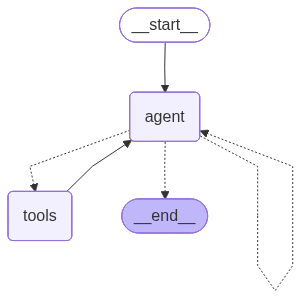

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [9]:
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
graph.invoke(
    input={"messages": [HumanMessage(content="How will the weather be tommorrow?")]},
    config={"recursion_limit": 25}
)

KeyboardInterrupt: 

In [ ]:
graph.invoke(input={
    "messages": [HumanMessage(content="Who is the owner and what are the timings?")]
})

In [12]:
# gym_agent_with_groq_fixed.py

import os
from typing import Annotated, Sequence, TypedDict, Literal

from dotenv import load_dotenv

# ---- LangChain base imports ----
from langchain.schema import Document
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool

# ---- Vector store + embeddings ----
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# ---- Tools ----
from langchain.tools.retriever import create_retriever_tool

# ---- Groq LLM ----
from langchain_groq import ChatGroq

# ---- LangGraph ----
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


# ============================================================
# 1. Load environment (GROQ_API_KEY must be set)
# ============================================================
load_dotenv()
# Ensure you have GROQ_API_KEY in your environment or .env


# ============================================================
# 2. Build documents and vectorstore
# ============================================================
embedding_function = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

docs = [
    Document(
        page_content=(
            "Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. "
            "With over 15 years of experience in professional athletics, Marcus established the "
            "gym to provide personalized fitness solutions for people of all levels. The gym spans "
            "10,000 square feet and features state-of-the-art equipment."
        ),
        metadata={"source": "about.txt"},
    ),
    Document(
        page_content=(
            "Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. "
            "On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national "
            "holidays. Members with Premium access can enter using their key cards 24/7, including holidays."
        ),
        metadata={"source": "hours.txt"},
    ),
    Document(
        page_content=(
            "Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; "
            "Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes "
            "24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen "
            "discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining."
        ),
        metadata={"source": "membership.txt"},
    ),
    Document(
        page_content=(
            "Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), "
            "HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and "
            "Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. "
            "The full schedule is available on our mobile app or at the reception desk."
        ),
        metadata={"source": "classes.txt"},
    ),
    Document(
        page_content=(
            "Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years "
            "of experience. Each new member receives a complimentary fitness assessment and one free session "
            "with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and "
            "sports-specific training. Personal training sessions can be booked individually (₹800/session) "
            "or in packages of 10 (₹7,000) or 20 (₹13,000)."
        ),
        metadata={"source": "trainers.txt"},
    ),
    Document(
        page_content=(
            "Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, "
            "functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and "
            "steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or "
            "upgraded every 3 years to ensure members have access to the latest fitness technology."
        ),
        metadata={"source": "facilities.txt"},
    ),
]

db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 3})


# ============================================================
# 3. Tools (retriever + off_topic)
# ============================================================
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Gym History & Founder, Operating Hours, Membership Plans, "
    "Fitness Classes, Personal Trainers, and Facilities & Equipment of Peak Performance Gym",
)


@tool
def off_topic():
    """Catch all Questions NOT related to Peak Performance Gym's history, hours, membership plans, fitness classes, trainers, or facilities"""
    return "Forbidden - do not respond to the user. The question is not about Peak Performance Gym."


tools = [retriever_tool, off_topic]


# ============================================================
# 4. LangGraph State
# ============================================================
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


# ============================================================
# 5. LLMs (Groq) – with and without tools
# ============================================================
# Tool-calling model
llm_with_tools = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
).bind_tools(tools)

# Plain model for final response (NO tools)
llm_plain = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
)


# ============================================================
# 6. Node functions
# ============================================================
def agent(state: AgentState) -> AgentState:
    """First LLM pass – allowed to call tools."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def final_answer(state: AgentState) -> AgentState:
    """
    Final LLM pass – NO tools.
    Uses tool results already in `messages` to answer the user.
    """
    messages = state["messages"]
    response = llm_plain.invoke(messages)
    return {"messages": [response]}


def route_after_agent(state: AgentState) -> Literal["tools", "end"]:
    """
    After the first agent call:
    - If it requested tools -> go to ToolNode.
    - Otherwise -> end.
    """
    last = state["messages"][-1]
    if isinstance(last, AIMessage) and getattr(last, "tool_calls", None):
        return "tools"
    return "end"


def route_after_tools(state: AgentState) -> Literal["final", "end"]:
    """
    After tools run:
    - If last tool was off_topic -> stop (we just return the tool message).
    - Otherwise -> go to final_answer to generate a natural answer.
    """
    last = state["messages"][-1]
    if isinstance(last, ToolMessage) and last.name == "off_topic":
        return "end"
    return "final"


# ============================================================
# 7. Build the graph
# ============================================================
workflow = StateGraph(AgentState)

# Nodes
workflow.add_node("agent", agent)
tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_node("final", final_answer)

# Edges
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    route_after_agent,
    {
        "tools": "tools",
        "end": END,
    },
)

workflow.add_conditional_edges(
    "tools",
    route_after_tools,
    {
        "final": "final",
        "end": END,
    },
)

workflow.add_edge("final", END)

# Compile graph
graph = workflow.compile()


# ============================================================
# 8. Example calls
# ============================================================
if __name__ == "__main__":
    # Off-topic question (should hit off_topic tool and stop)
    print("=== Off-topic question ===")
    result1 = graph.invoke(
        {"messages": [HumanMessage(content="How will the weather be tomorrow?")]},
        config={"recursion_limit": 25},
    )
    for m in result1["messages"]:
        print(type(m).__name__, ":", getattr(m, "content", None))

    print("\n=== On-topic question ===")
    result2 = graph.invoke(
        {"messages": [HumanMessage(content="Who is the owner and what are the timings?")]},
        config={"recursion_limit": 25},
    )
    for m in result2["messages"]:
        print(type(m).__name__, ":", getattr(m, "content", None))


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 24429cf6-1ef3-4a09-89b6-b90c13eb5803)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


=== Off-topic question ===
HumanMessage : How will the weather be tomorrow?
AIMessage : 
ToolMessage : Forbidden - do not respond to the user. The question is not about Peak Performance Gym.

=== On-topic question ===
HumanMessage : Who is the owner and what are the timings?
AIMessage : 
ToolMessage : Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.

Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.

Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group